## Import libraries

In [35]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import ydf

## Adding dataset and EDA

In [22]:
dataset = pd.read_csv('german_credit_data.csv')

dataset.head(20)
dataset['Risk'] = dataset['Risk'].replace({ 0 : "good", 1 : 'bad'})

In [23]:
dataset.head(10)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad
5,5,35,male,1,free,NaN,NaN,9055,36,education,good
6,6,53,male,2,own,quite rich,NaN,2835,24,furniture/equipment,good
7,7,35,male,3,rent,little,moderate,6948,36,car,good
8,8,61,male,1,own,rich,NaN,3059,12,radio/TV,good
9,9,28,male,3,own,little,moderate,5234,30,car,bad


In [24]:
X = dataset.drop(columns='Risk')
y = dataset['Risk']

print(f'X = {X}\n')
print(f'y ={y}')

X =      Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0             0   67    male    2     own             NaN           little   
1             1   22  female    2     own          little         moderate   
2             2   49    male    1     own          little              NaN   
3             3   45    male    2    free          little           little   
4             4   53    male    2    free          little           little   
..          ...  ...     ...  ...     ...             ...              ...   
995         995   31  female    1     own          little              NaN   
996         996   40    male    3     own          little           little   
997         997   38    male    2     own          little              NaN   
998         998   23    male    2    free          little           little   
999         999   27    male    2     own        moderate         moderate   

     Credit amount  Duration              Purpose  
0      

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8)

## Basel 3 compliance components

### Probability by default

Train model on 1000 examples
Model trained in 0:00:01.060423


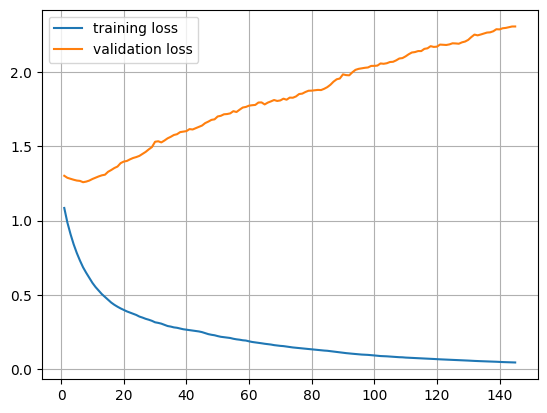

In [38]:
PDmodel = ydf.GradientBoostedTreesLearner(
    label="Risk",
    num_trees=145,
    early_stopping_num_trees_look_ahead=1000
).train(dataset)
PDmodel.describe()

logs = PDmodel.training_logs()

iterations = [ log.iteration for log in logs ]
training_loss = [ log.training_evaluation.loss for log in logs ]
validation = [ log.evaluation.loss for log in logs ]



plt.plot( iterations, training_loss, label='training loss' )
plt.plot( iterations, validation, label='validation loss' )
plt.legend()
plt.grid()
plt.show()

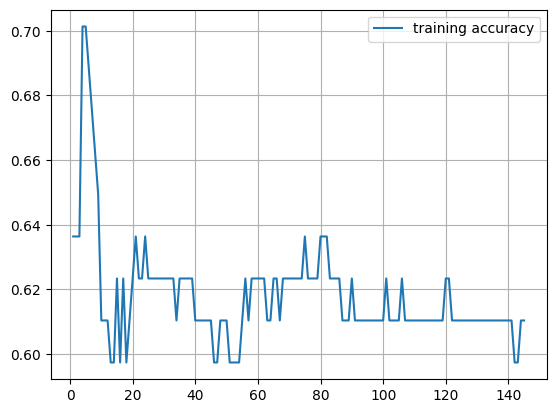

In [41]:
training_accuracy = [ log.evaluation.accuracy for log in logs ]

plt.plot( iterations, training_accuracy, label='training accuracy' )
plt.legend()
plt.grid()
plt.show()

In [27]:
ls_pd_pred = []

for predicted_val in PDmodel.predict(X):
    ls_pd_pred.append( float(predicted_val) )

print(ls_pd_pred)

[0.8589126467704773, 0.3267619013786316, 0.8310878872871399, 0.5634552240371704, 0.5807306170463562, 0.8309304714202881, 0.8684715032577515, 0.5840096473693848, 0.8882387280464172, 0.5689727067947388, 0.6133633852005005, 0.3349403440952301, 0.7717191576957703, 0.42116302251815796, 0.7434121370315552, 0.3693232834339142, 0.8621094822883606, 0.6755508780479431, 0.4063386917114258, 0.8431852459907532, 0.8946884870529175, 0.8867499232292175, 0.8920145034790039, 0.7893190383911133, 0.8686575889587402, 0.8513407707214355, 0.8645179867744446, 0.7856947779655457, 0.8855633735656738, 0.41470351815223694, 0.8435055017471313, 0.5780087113380432, 0.767310619354248, 0.8795204758644104, 0.828775942325592, 0.44567209482192993, 0.7858819365501404, 0.7898672223091125, 0.7530323266983032, 0.7979558110237122, 0.8364344835281372, 0.688255786895752, 0.7304364442825317, 0.5588904619216919, 0.40948259830474854, 0.8823994398117065, 0.8471642732620239, 0.7488312721252441, 0.7255372405052185, 0.8805791139602661

In [28]:
# tuner = ydf.RandomSearchTuner(num_trials=50)
# tuner.choice("shrinkage", [0.2, 0.1, 0.05])
# tuner.choice("subsample", [1.0, 0.9, 0.8])
# tuner.choice("max_depth", [3, 4, 5, 6])

# model_01 = ydf.GradientBoostedTreesLearner(label='Success', tuner=tuner, num_trees=100).train(dataset)
# model_01.describe()

## Loss given default

In [29]:
LGDModel = RandomForestRegressor(n_estimators=1000)

def generate_synthetic_lgd_col( dataset ):

    """
    Basel III ranges an LGD of 45% on unsecured loans.
    """

    lgd = []

    np.random.seed(42)

    for _, row in dataset.iterrows():

        # collateral: housing
        if ( row['Housing'] == 'own' ): base_lgd = 0.30
        elif ( row['Housing'] == 'rent'): base_lgd = 0.50
        else: base_lgd = 0.45

        # loan purpose
        if ( row['Purpose'] in ['car', 'radio/TV', 'furniture/equipment'] ): base_lgd += 0.05
        elif ( row['Purpose'] == 'education' ): base_lgd -= 0.10

        lgd_val = base_lgd + np.random.normal( 0, 0.05 )
        lgd.append( np.clip( lgd_val, 0.1, 0.9 )  )

    return np.array( lgd )

In [30]:
loan_lgd_val = generate_synthetic_lgd_col( dataset )

print(loan_lgd_val)

[0.37483571 0.34308678 0.23238443 0.57615149 0.48829233 0.33829315
 0.42896064 0.58837174 0.32652628 0.377128   0.52682912 0.47671351
 0.36209811 0.25433599 0.46375411 0.32188562 0.29935844 0.31571237
 0.4545988  0.27938481 0.42328244 0.53871118 0.55337641 0.27876259
 0.32278086 0.35554613 0.29245032 0.5687849  0.31996807 0.28541531
 0.26991467 0.44261391 0.34932514 0.44711445 0.39112725 0.28895782
 0.36044318 0.25201649 0.2335907  0.35984306 0.38692333 0.35856841
 0.29421759 0.53494482 0.4260739  0.31400779 0.32696806 0.60285611
 0.36718091 0.26184799 0.3662042  0.33074589 0.3161539  0.38058381
 0.55154998 0.39656401 0.30803912 0.33453938 0.36656317 0.59877726
 0.27604129 0.34071705 0.39468325 0.24018967 0.39062629 0.367812
 0.34639949 0.40017664 0.3680818  0.31774401 0.36806978 0.62690183
 0.4482087  0.37823218 0.1        0.54109513 0.35435235 0.33504963
 0.35458804 0.25062155 0.33901641 0.36785563 0.5738947  0.27408649
 0.30957532 0.27491215 0.39577011 0.36643756 0.32351199 0.325663

## Exposure at default

In [31]:
def calculate_ead_col( amount_lent, duration: int, months_passed=0 ):

    """
    EAD - metric showing how much the lender can manage the loss
    """

    montly_rate = 0.11 / 12

    if ( months_passed == 0 ): return amount_lent
    # NOTE: for german_credit_data.csv this is always true as the data is from when the loans
    # were accepted or not

    return

## Calculating expected loss (Basel III formula)

In [33]:
# EL = PD * LGD * EAD

dataset['PD'] = 1 - PDmodel.predict( X )        # inversion - model counts
dataset['LGD'] = generate_synthetic_lgd_col( dataset )
dataset['EAD'] = dataset.apply( lambda row: calculate_ead_col( row['Credit amount'], row['Duration']), axis=1 )

dataset['expected_loss'] = dataset['PD'] * dataset['LGD'] * dataset['EAD']

dataset.head(100)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,PD,LGD,EAD,expected_loss
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good,0.141087,0.374836,1169,61.822072
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad,0.673238,0.343087,5951,1374.556593
2,2,49,male,1,own,little,NaN,2096,12,education,good,0.168912,0.232384,2096,82.273333
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good,0.436545,0.576151,7882,1982.448516
4,4,53,male,2,free,little,little,4870,24,car,bad,0.419269,0.488292,4870,997.015739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,58,male,2,rent,little,moderate,15945,54,business,bad,0.680275,0.426824,15945,4629.756774
96,96,61,female,2,own,NaN,NaN,2012,12,education,good,0.134876,0.214806,2012,58.292075
97,97,34,male,2,own,moderate,moderate,2622,18,business,good,0.232689,0.313053,2622,190.997109
98,98,36,male,2,own,little,moderate,2337,36,radio/TV,good,0.415990,0.350256,2337,340.507866
